In [19]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import math



# 4.2 Linear Regression

Think of the value at time t as function of earlier values  
Start by assuming it's a function of just the previous value and build off that.

In [5]:
tesla_tick = yf.Ticker('TSLA')
observed = tesla_tick.history(period='1d', start='2014-01-01', end='2022-03-01')['Close'].rename('Observed')
tesla_frame = pd.DataFrame(observed)
tesla_frame.head()

,Observed
Date,
2014-01-02,30.020000
2014-01-03,29.912001
2014-01-06,29.400000
2014-01-07,29.872000
2014-01-08,30.256001


<AxesSubplot:xlabel='Date'>

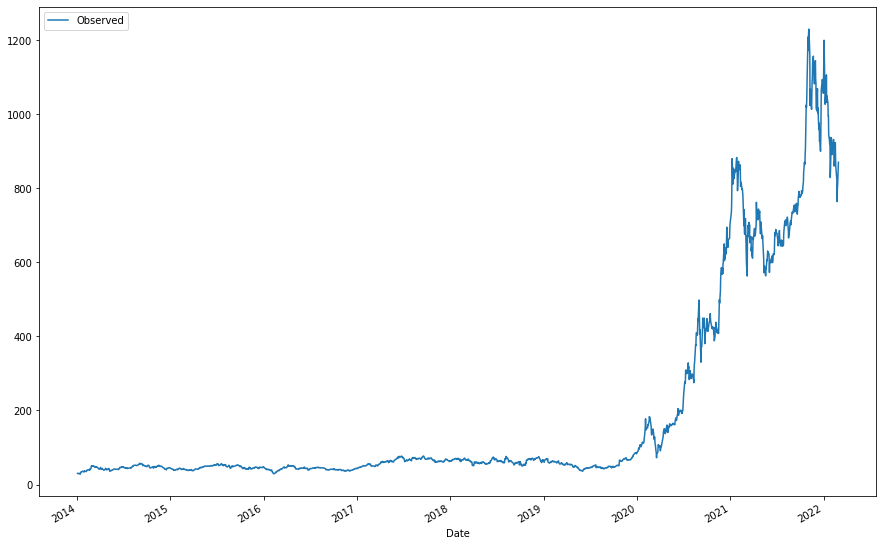

In [6]:
plt.rcParams['figure.figsize'] = [15,10]
tesla_frame.plot()

Graph is the share price of Tesla as a function of time.  
We don't want this, we want to think about how we can make the share price as a function of previous share prices.  
Hard to do as a graph except if I do one previous share price

Scatter plot share price against previous share price

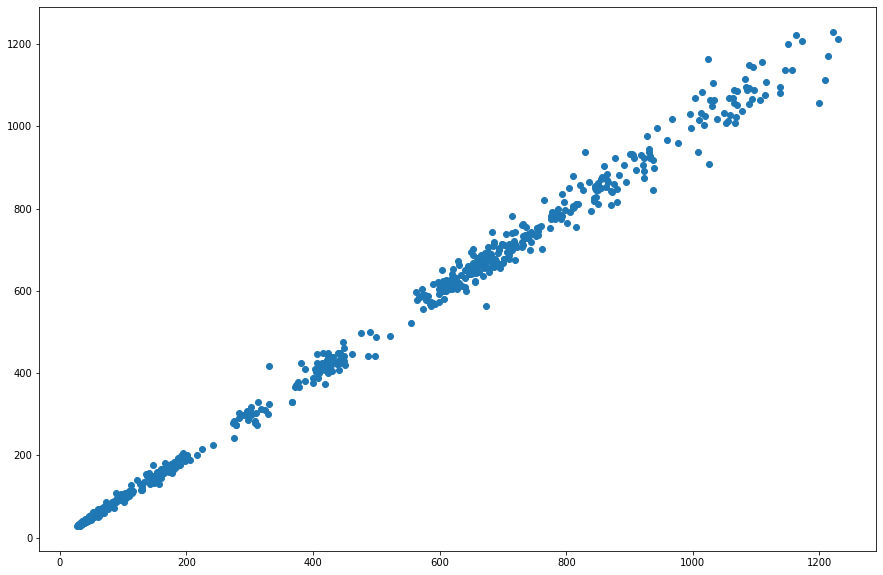

In [7]:
plt.scatter(observed, observed.shift())

Looks very linear. Going to do in the topic is to make that precise and use it as a way of predicting values.  
Topics to Cover:
- LinReg (both math and programming)
- MLR (math up to a point and programming)
- Correlations to det. how multiple to be in particular case
- Trading simulations


# 4.3 - Linear Regression Programming

0.5637254901960784


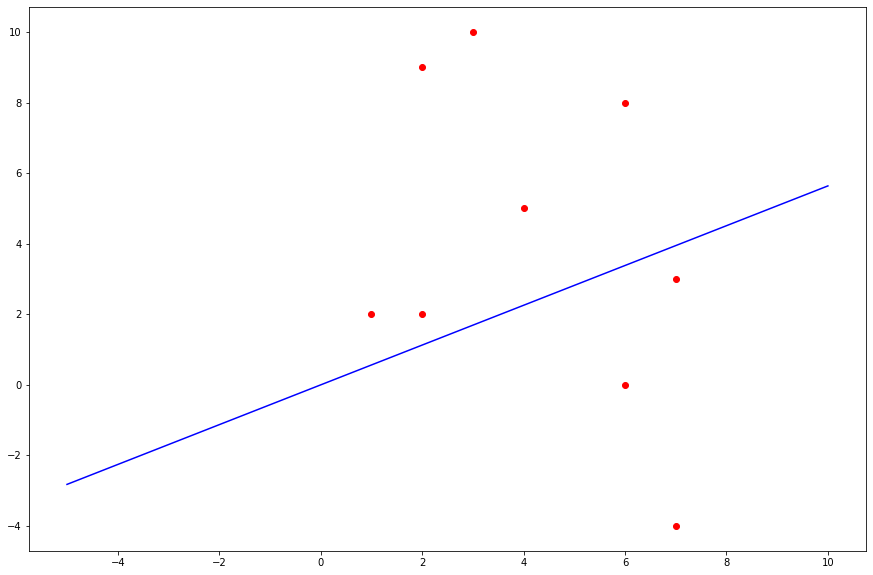

In [14]:
fig, ax = plt.subplots()

xs = np.array([1,2,3,4,7,2,6,7,6])
ys = np.array([2,9,10,5,3,2,0,-4,8])

for (xi, yi) in zip(xs,ys):
    ax.plot(xi,yi, '-ro')

# Numpy Dot Product
# https://numpy.org/doc/stable/reference/generated/numpy.dot.html 

# take each x value and y value - multiply them together and add up sum of each
numerator = np.dot(xs, ys)
# take each x value  - square it and add up sum of each
denominator = np.dot(xs, xs)
slope = numerator/denominator
print(slope)
x = np.linspace(-5,10)
y = slope*x
plt.plot(x, y, '-b')
plt.show()

# 5 - Multi-Linear Regression

Take same data as before but will not assume it goes through origin.  
If we want to do the matrix forumlation to have the bias, take the Xs and next to them put 1's.  
We have a col that has all the X values and a column of ones = X matrix

In [21]:
ones = np.array([1]*xs.size)

# 2 rows x's and 1's
X_trans = np.array([xs, ones])
# need the transpose of this => columns
X = X_trans.transpose()

# C = coefficients
# use linear algebra inverter for first part of formula
C = np.linalg.inv(X_trans @ X) @ X_trans @ ys

# C is an array [slope, y-int / bias]
print('Slope: ', C[0], '\nY-int / Bias: ', C[1])

Slope:  -0.7525510204081632 
Y-int / Bias:  7.066326530612243


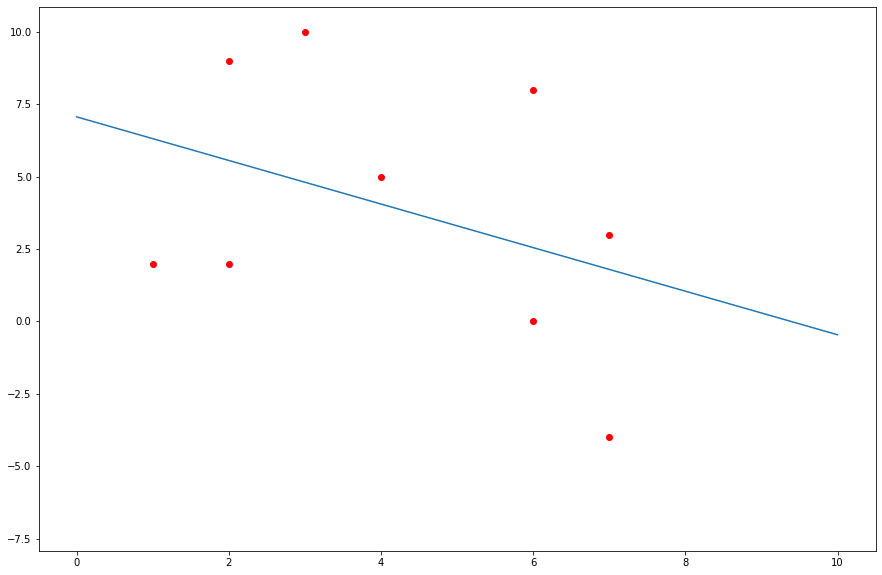

In [23]:
fig, ax = plt.subplots()

for (xi,yi) in zip(xs,ys):
    ax.plot(xi,yi,'-ro')

slope = C[0]
b = C[1]

x = np.linspace(0,10)
y = slope*x + b

plt.plot(x,y, -b)


# Auto Regression - AR(p)
A = auto  
R = regression  
p = paramater

X = design matrix

Training and Testing data  
training data is used to calculate the coefficients of the linear combinations  


In [15]:
# values is training set vector
# order = the p
def train_ar(values, order):
    # y, training data without first order p values
    target_vector = np.array(values[order:])
    lagged_values = []

    # build design matrix
    for i in range(len(values) - order):
        lagged_values.append(values[i: i+order])
    design_matrix = np.array(lagged_values)
    # print(design_matrix)
    # print(target_vector)
    # @ symbol effictively is multiplying matrices
    # linalg.inv = linear algebra.inverse
    return np.linalg.inv(design_matrix.transpose() @ design_matrix) @ design_matrix.transpose() @ target_vector



In [17]:
coeffs_test = train_ar([1,2,3,4,5.1,6,7,8,9], 4)
print(coeffs_test)

[-0.49680463  0.00136684  0.49953831  0.99770978]


In [22]:
ticker = yf.Ticker('TSLA')
# get daily closing stock price for tesla
observed = ticker.history(period='1d', start='2014-01-01', end='2022-03-01')['Close']

In [23]:
# create training data, take log, then after predictions convert back
training_data = np.log(observed['2014-01-01':'2021-01-01'])
model_coeffs = train_ar(training_data, 3)

print(model_coeffs)

[-0.04233185  0.03729354  1.00548829]


# 4.8 Python for predicting and testing AR(p)

In [26]:
# coeffs = array of coefficients, length = p
# values = dataset predicting off of

def predict(coeffs, values):
    # create init array of nan's with length of len(coeffs)
    predicted_vals = [math.nan] * len(coeffs)

    #every time go through loop append new prediction

    for i in range(len(coeffs), len(values)):
        # prediction = linear combination of coefficients and the last 'p' values
        # moving window of 'p' things for dot product
        predicted_vals.append(np.dot(coeffs, values[i-len(coeffs):i]))
    # return predicted values array
    return np.array(predicted_vals)

pred_test = predict(coeffs_test, [10,11,12,13,14,15,16,17])
print(pred_test)

[        nan         nan         nan         nan 14.01167569 15.01348598
 16.01529627 17.01710656]


In [31]:
# TESLA DATA

# test data is the remaining data from the dataset
test_data = observed['2021-01-01': '2022-03-01']

# take log of the test data
log_prediction = predict(model_coeffs, np.log(test_data))

In [32]:
test_data = test_data.to_frame()

#convert predictions back from logs by using exp
test_data['prediction'] = np.exp(log_prediction)

#drop nas
test_data=test_data.dropna()


<AxesSubplot:xlabel='Date'>

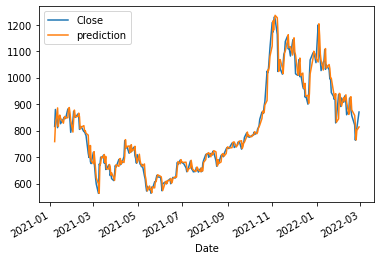

In [33]:
test_data.plot()

### Compute standard deviations

In [39]:
def assess_predictions(df):
    total_error_sqr = 0
    total_predicted = 0
    predictions = df['prediction']
    values = df['Close']
    for value, prediction in zip(values, predictions):
        if prediction > 0 and value > 0:
            total_error_sqr += (prediction-value)**2
            total_predicted += 1
    return total_error_sqr / total_predicted


std_dev = math.sqrt(assess_predictions(test_data))
std_dev

31.463033666344497

# 4.9 Simulated Trading

Use prediction to decide when I'm going to buy Tesla shares  
Decision rule: is prediction going to be 0.04% higher than yesterday?  
- yes = buy / hold
- no = don't buy / sell

In [41]:
# create new column called 'is_holding'
# if prediction is more than 1.04 times last close, then I'll hold, otherwise won't
test_data['is_holding'] = test_data['prediction'] > test_data['Close'].shift()*1.004

#last price when I held shares
last_price = None


portfolio_value = 10000
values = []

for ts, (close, _, is_holding) in test_data.iterrows():
    # if holding recalculate how value of portfolio
    # take money used to have and multiply it by new close / last price
    # if last price = close then no change in value
    if is_holding:
        portfolio_value *= close / last_price
    # set new last_price
    last_price = close
    # add to list of portfolio values
    values.append(portfolio_value)

test_data['EquityValue'] = values



In [42]:
test_data.head()

,Close,prediction,is_holding,EquityValue
Date,,,,
2021-01-07,816.039978,758.579086,False,10000.000000
2021-01-08,880.020020,819.791859,True,10784.030724
2021-01-11,811.190002,885.907031,True,9940.566936
2021-01-12,849.440002,815.907874,True,10409.293972
2021-01-13,854.409973,849.286672,False,10409.293972


<AxesSubplot:xlabel='Date'>

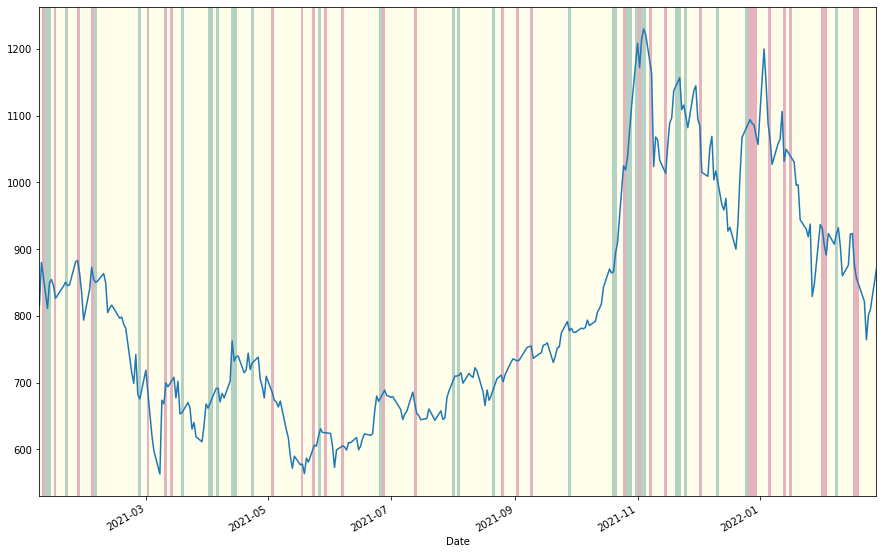

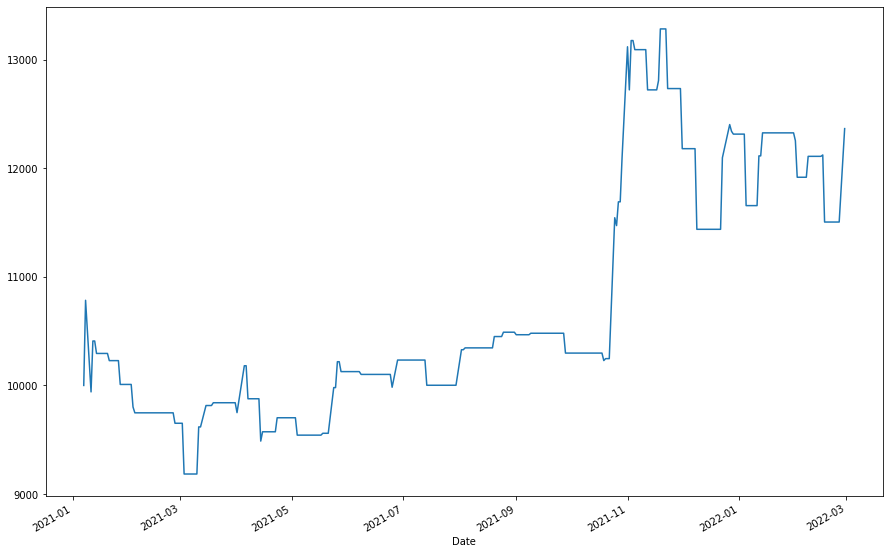

In [45]:
offsets = (test_data['is_holding'] * (test_data['Close'].shift(-1) - test_data['Close']))

has_increased = ((test_data['Close'].shift(-1) > test_data['Close']) & test_data['is_holding']).astype(int)
has_decreased = ((test_data['Close'].shift(-1) < test_data['Close']) & test_data['is_holding']).astype(int)

plt.rcParams['figure.figsize'] = [15, 10]
ax = test_data['Close'].plot()
offset_start = has_increased.index[0].timestamp() / 24 / 60 / 60
offset_end = has_increased.index[-1].timestamp() / 24 / 60 / 60
ax.pcolorfast((offset_start, offset_end), ax.get_ylim(), (has_increased - has_decreased).values[np.newaxis], cmap='RdYlGn', alpha = 0.3)

plt.figure()
test_data['EquityValue'].plot()

Top graph is trading graph. Blue is share price.  
Notice price at end is similar to start.  
Pink are losing days where green is winning days.  

Second graph is portfolio value.  
Has risen despite price is about the same as start.  

# 4.10 Correlation

How to decide what p to use in an AR(p) model.  
Correlation = how much one quantity has to do with another  
Which of the lags are relevant to the calculation of the present value   

Going to look at what correlation seems to be in the historical data on each of the values with their respective lags.  
Whether they seem like one before, two before, three before etc.  

1 and -1 perfectly positively / negatively correlated   
0 = no correlation

### Autocorrelation
Correlation of a time series observations 

### Partial Autocorrelation - Autoregression
Use **Partial Correlation**

"The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags." (https://amzn.to/2XYS8DD)

Autocorrelation function tells you how correlated you are with each of your lags

Partial autocorrelation much more complicated

How correlated lag 3 is but without taking into account how lag 3 has affected lags 2 and 1 in between

Normally lag 3 correlation will include the indirect effects going through lags 1 and 2 as well - want to not have those counted.

# 4.11 Using Stats Models to do AR(p)



In [7]:
import numpy as np
def pearson_cc (xs, ys):
    x_mean = np.average(xs)
    y_mean = np.average(ys)
    xs_diffs = xs-x_mean
    ys_diffs = ys-y_mean
    numerator = np.dot(xs_diffs, ys_diffs)
    denominator = np.sqrt((np.dot(xs_diffs,xs_diffs) * np.dot(ys_diffs, ys_diffs)))
    return numerator / denominator

In [12]:
xs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ys = np.array([1, 3, 6, 10, 15, 21, 28, 36, 45, 55])

print(pearson_cc(xs, ys))
print(pearson_cc(xs, 2*xs))
print(pearson_cc(xs, -1*xs))

0.9784921095801632
1.0
-1.0


sunspots = sm.datasets.sunspots.load_pandas().data


<AxesSubplot:>

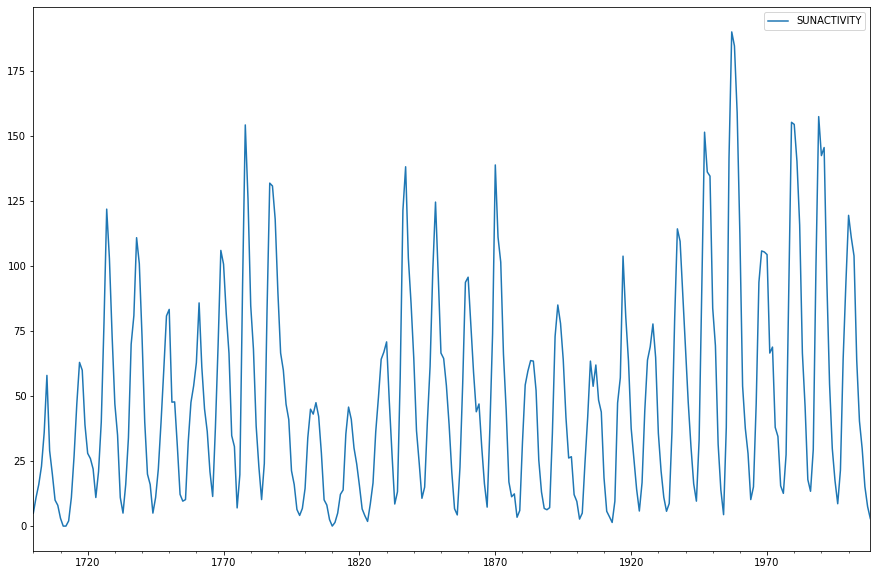

In [48]:
import statsmodels.api as sm
sunspots = sm.datasets.sunspots.load_pandas().data
sunspots.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
del sunspots['YEAR']
sunspots.plot()

In [49]:
# make a frame with the only col being the data of interest = "Observed"

sunspots = sunspots['SUNACTIVITY'].rename('Observed').to_frame()
sunspots.head()

,Observed
1700-12-31,5.0
1701-12-31,11.0
1702-12-31,16.0
1703-12-31,23.0
1704-12-31,36.0


In [50]:
# make a frame with training data = sunspots up to 1950
training_df = sunspots['Observed']['1700':'1950'].to_frame()
print(training_df)

            Observed
1700-12-31       5.0
1701-12-31      11.0
1702-12-31      16.0
1703-12-31      23.0
1704-12-31      36.0
...              ...
1946-12-31      92.6
1947-12-31     151.6
1948-12-31     136.3
1949-12-31     134.7
1950-12-31      83.9

[251 rows x 1 columns]


Plot the pcf  
notice that the pcf I have a parameter for lags  
This tells Python to look no further than that many lags

```plot_pcf = Plot the partial autocorrelation function```

c:\Users\hugho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


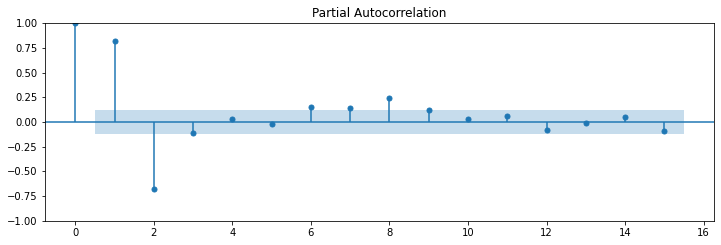

In [53]:
fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(training_df, lags=15, ax=ax2)

Looking at correlation values in the plot, the blue shading means value lies in realm where not correlated enough to be considered in model. Anything outside of that should be included in the model.   

looks like 1,2 and 8 are relevent ones  
One advantage of the sm implementation comes in. Can specify these three instead of just saying AP(8)    

Call the ```AutoReg``` function



In [55]:
results = sm.tsa.AutoReg(training_df, [1,2,8]).fit()
print(results.summary())

                            AutoReg Model Results                             
Dep. Variable:               Observed   No. Observations:                  251
Model:              Restr. AutoReg(8)   Log Likelihood                -993.261
Method:               Conditional MLE   S.D. of innovations             14.419
Date:                Mon, 04 Jul 2022   AIC                           1996.523
Time:                        22:02:31   BIC                           2013.988
Sample:                    12-31-1708   HQIC                          2003.558
                         - 12-31-1950                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.1570      2.338      2.633      0.008       1.574      10.740
Observed.L1     1.3274      0.047     28.400      0.000       1.236       1.419
Observed.L2    -0.5975      0.051    -11.829    

c:\Users\hugho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)


c:\Users\hugho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


<AxesSubplot:>

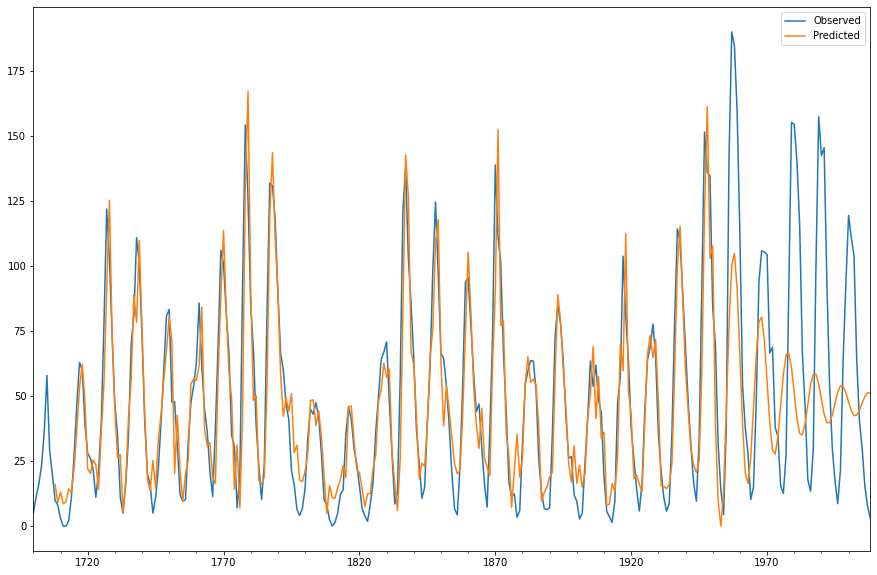

In [56]:
# when did this without the "end='2008'" it seemed to stop at end of training period so did this instead
sunspots['Predicted'] = results.predict(end='2008')
sunspots.plot()